In [21]:
import numpy as np
import pandas as pd

# Setting a seed for reproducibility
np.random.seed(42)

# Number of samples per group
n_samples = 100

# Simulating data for Group A
age_A = np.random.normal(loc=30, scale=5, size=n_samples)  # Age: mean 30, std deviation 5
income_A = np.random.normal(loc=50000, scale=8000, size=n_samples)  # Income: mean 50000, std deviation 8000
score_A = np.random.normal(loc=75, scale=10, size=n_samples)  # Score: mean 75, std deviation 10

# Simulating data for Group B
age_B = np.random.normal(loc=35, scale=5, size=n_samples)  # Age: mean 35, std deviation 5
income_B = np.random.normal(loc=55000, scale=10000, size=n_samples)  # Income: mean 55000, std deviation 10000
score_B = np.random.normal(loc=75, scale=15, size=n_samples)  # Score: same mean, different std deviation

# Creating DataFrames
data_A = pd.DataFrame({'Group': 'A', 'Age': age_A, 'Income': income_A, 'Score': score_A})
data_B = pd.DataFrame({'Group': 'B', 'Age': age_B, 'Income': income_B, 'Score': score_B})

# Combining into a single DataFrame
data = pd.concat([data_A, data_B], ignore_index=True)
# Adding gender
genders = np.random.choice(['Male', 'Female'], size=2*n_samples)
data['Gender'] = genders

# Simulating 'Satisfaction' feature using a beta distribution
satisfaction_A = np.random.beta(a=2, b=5, size=n_samples) * 100  # More skewed distribution
satisfaction_B = np.random.beta(a=5, b=2, size=n_samples) * 100  # Less skewed, higher mean
satisfaction = np.concatenate([satisfaction_A, satisfaction_B])
data['Satisfaction'] = satisfaction
# Simulating 'Stress Level' using a beta distribution, modified by group and gender
stress_A = np.random.beta(a=2, b=5, size=n_samples) * 100
stress_B = np.random.beta(a=3, b=2, size=n_samples) * 100
stress = np.concatenate([stress_A, stress_B])
data['Stress'] = stress

# Modify Stress Level specifically for males in Group B
data.loc[(data['Group'] == 'B') & (data['Gender'] == 'Male'), 'Stress'] *= 0.8  # Decrease stress by 20%

# Modify Score for males in Group B to increase by 20%
data.loc[(data['Group'] == 'B') & (data['Gender'] == 'Male'), 'Score'] *= 1.2


# Adjusting 'Score' to be affected by gender particularly for males in Group B
data.loc[(data['Group'] == 'B') & (data['Gender'] == 'Male'), 'Score'] *= 1.1  # Increase score by 10%

data.head()

,Group,Age,Income,Score,Gender,Satisfaction,Stress
0,A,32.483571,38677.034064,78.577874,Male,28.538579,45.244464
1,A,29.308678,46634.837418,80.607845,Female,51.430969,20.301202
2,A,33.238443,47258.283868,85.830512,Female,15.648980,24.151842
3,A,37.615149,43581.781846,85.538021,Male,26.055753,27.934867
4,A,28.829233,48709.714307,61.223306,Female,13.981359,17.819210


In [29]:
data

,Group,Age,Income,Score,Gender,Satisfaction,Stress
0,A,32.483571,38677.034064,78.577874,Male,28.538579,45.244464
1,A,29.308678,46634.837418,80.607845,Female,51.430969,20.301202
2,A,33.238443,47258.283868,85.830512,Female,15.648980,24.151842
3,A,37.615149,43581.781846,85.538021,Male,26.055753,27.934867
4,A,28.829233,48709.714307,61.223306,Female,13.981359,17.819210
...,...,...,...,...,...,...,...
195,B,32.654122,60389.100437,88.901675,Male,72.951535,64.089034
196,B,26.434327,44627.538457,93.656476,Male,36.969980,61.719593
197,B,41.769362,53096.613219,79.620478,Male,46.654089,60.287763
198,B,34.427301,46243.817466,68.335601,Female,79.258335,52.181523


In [33]:
from scipy.stats import ttest_ind, levene

# T-tests for Age and Income
t_test_age = ttest_ind(data_A['Age'], data_B['Age'])
t_test_income = ttest_ind(data_A['Income'], data_B['Income'])

# F-test (Levene's test) for equality of variances in Score and stress
f_test_score = levene(data_A['Score'], data_B['Score'])
levene_stress = levene(data[data['Group'] == 'A']['Stress'], data[data['Group'] == 'B']['Stress'])
# Display the results of the tests
t_test_age, t_test_income, f_test_score, levene_stress

(TtestResult(statistic=-9.552217388696766, pvalue=5.053016668556966e-18, df=198.0),
 TtestResult(statistic=-3.2554470823191273, pvalue=0.001331661392154832, df=198.0),
 LeveneResult(statistic=5.776967132033392, pvalue=0.017159677483003618),
 LeveneResult(statistic=3.4382747890147676, pvalue=0.06518937054231835))

In [36]:
from scipy.stats import ttest_ind
from statsmodels.formula.api import ols
import statsmodels.api as sm
# Welch's t-tests for Score and Stress without assuming equal variances
t_test_score_updated = ttest_ind(data[data['Group'] == 'A']['Score'], data[data['Group'] == 'B']['Score'], equal_var=False)
t_test_stress_updated = ttest_ind(data[data['Group'] == 'A']['Stress'], data[data['Group'] == 'B']['Stress'], equal_var=False)

# Conducting ANOVA to investigate interaction effects
# Setting up the model for Score with interaction between Group and Gender
model_score = ols('Score ~ C(Group) * C(Gender)', data=data).fit()
anova_score = sm.stats.anova_lm(model_score, typ=2)

# Setting up the model for Stress with interaction between Group and Gender
model_stress = ols('Stress ~ C(Group) * C(Gender)', data=data).fit()
anova_stress = sm.stats.anova_lm(model_stress, typ=2)

t_test_score_updated, t_test_stress_updated, anova_score, anova_stress

(TtestResult(statistic=-4.324036477897748, pvalue=2.7459523852894564e-05, df=153.43156353107798),
 TtestResult(statistic=-10.257281798013233, pvalue=6.747145607130168e-20, df=188.50119434270468),
                           sum_sq     df          F        PR(>F)
 C(Group)             4666.702642    1.0  24.405650  1.668280e-06
 C(Gender)            5369.424732    1.0  28.080705  3.115682e-07
 C(Group):C(Gender)   7643.346301    1.0  39.972728  1.703255e-09
 Residual            37477.949029  196.0        NaN           NaN,
                           sum_sq     df           F        PR(>F)
 C(Group)            28337.086326    1.0  108.335078  1.771189e-20
 C(Gender)            1510.647445    1.0    5.775333  1.718468e-02
 C(Group):C(Gender)    309.142275    1.0    1.181877  2.783093e-01
 Residual            51267.502778  196.0         NaN           NaN)

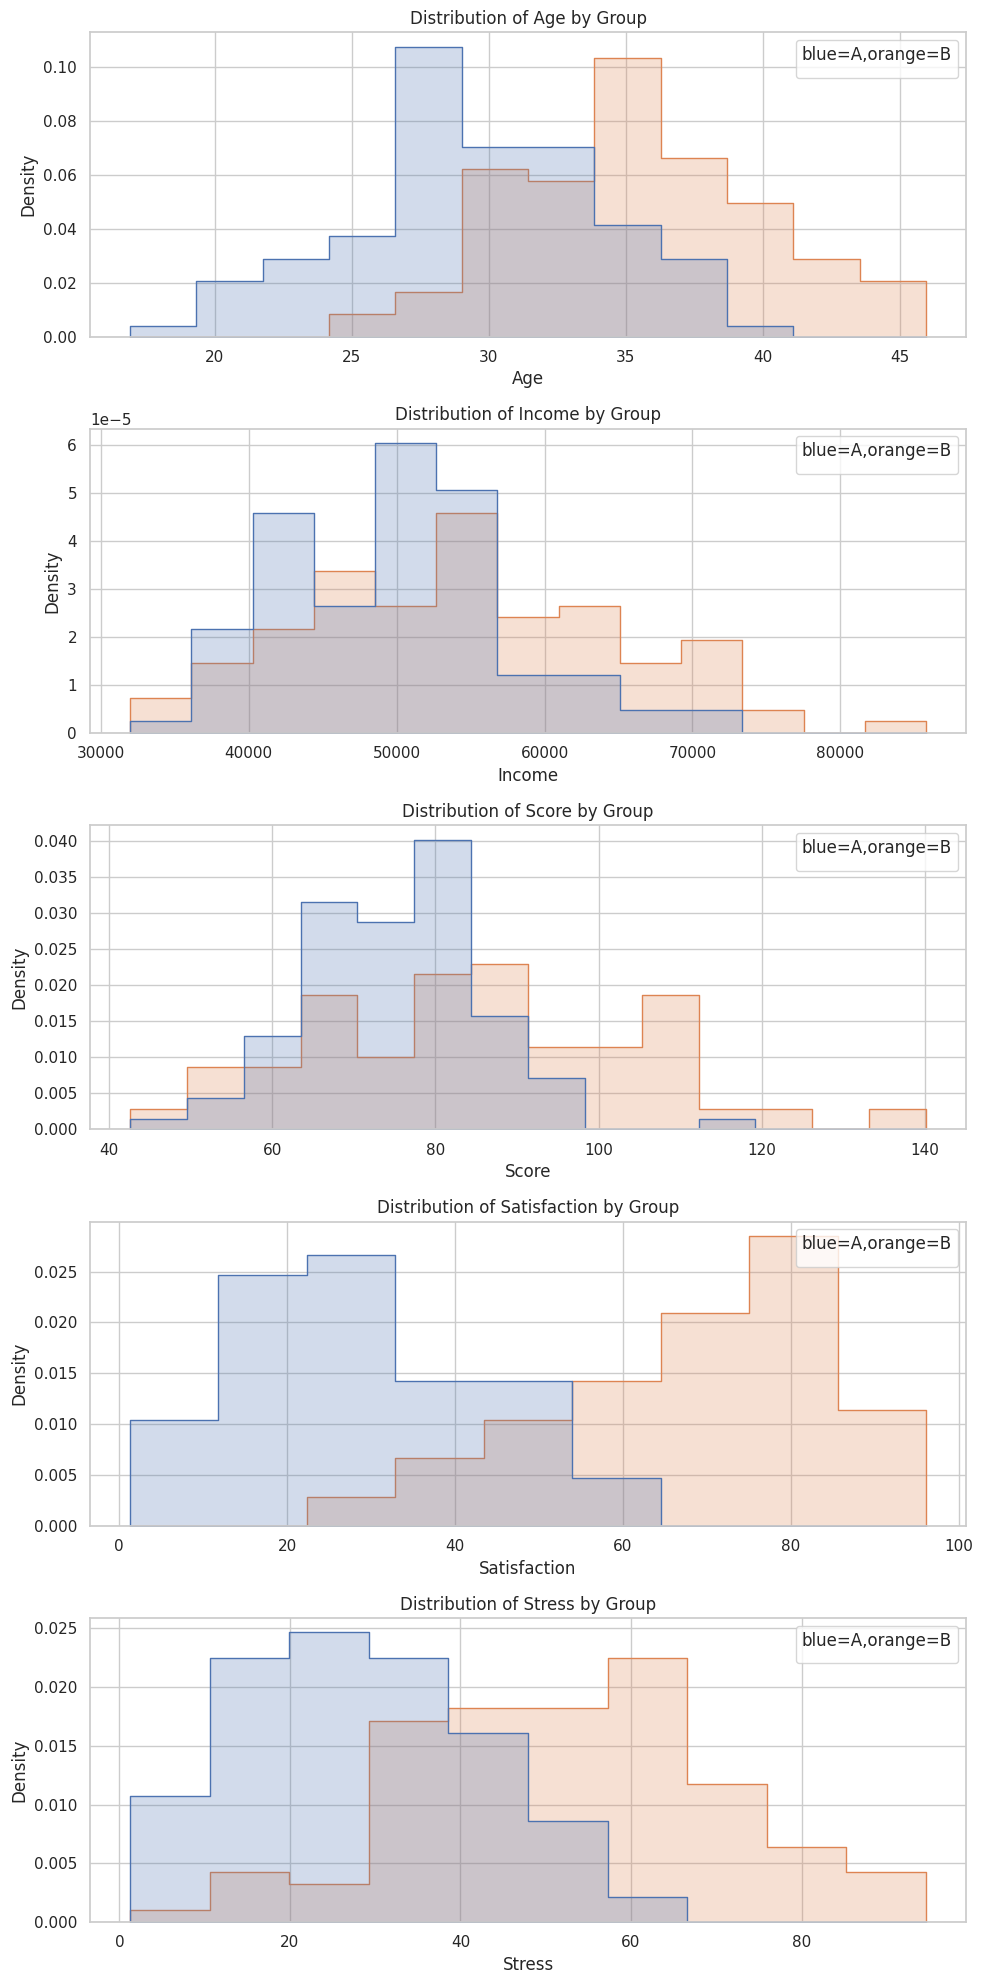

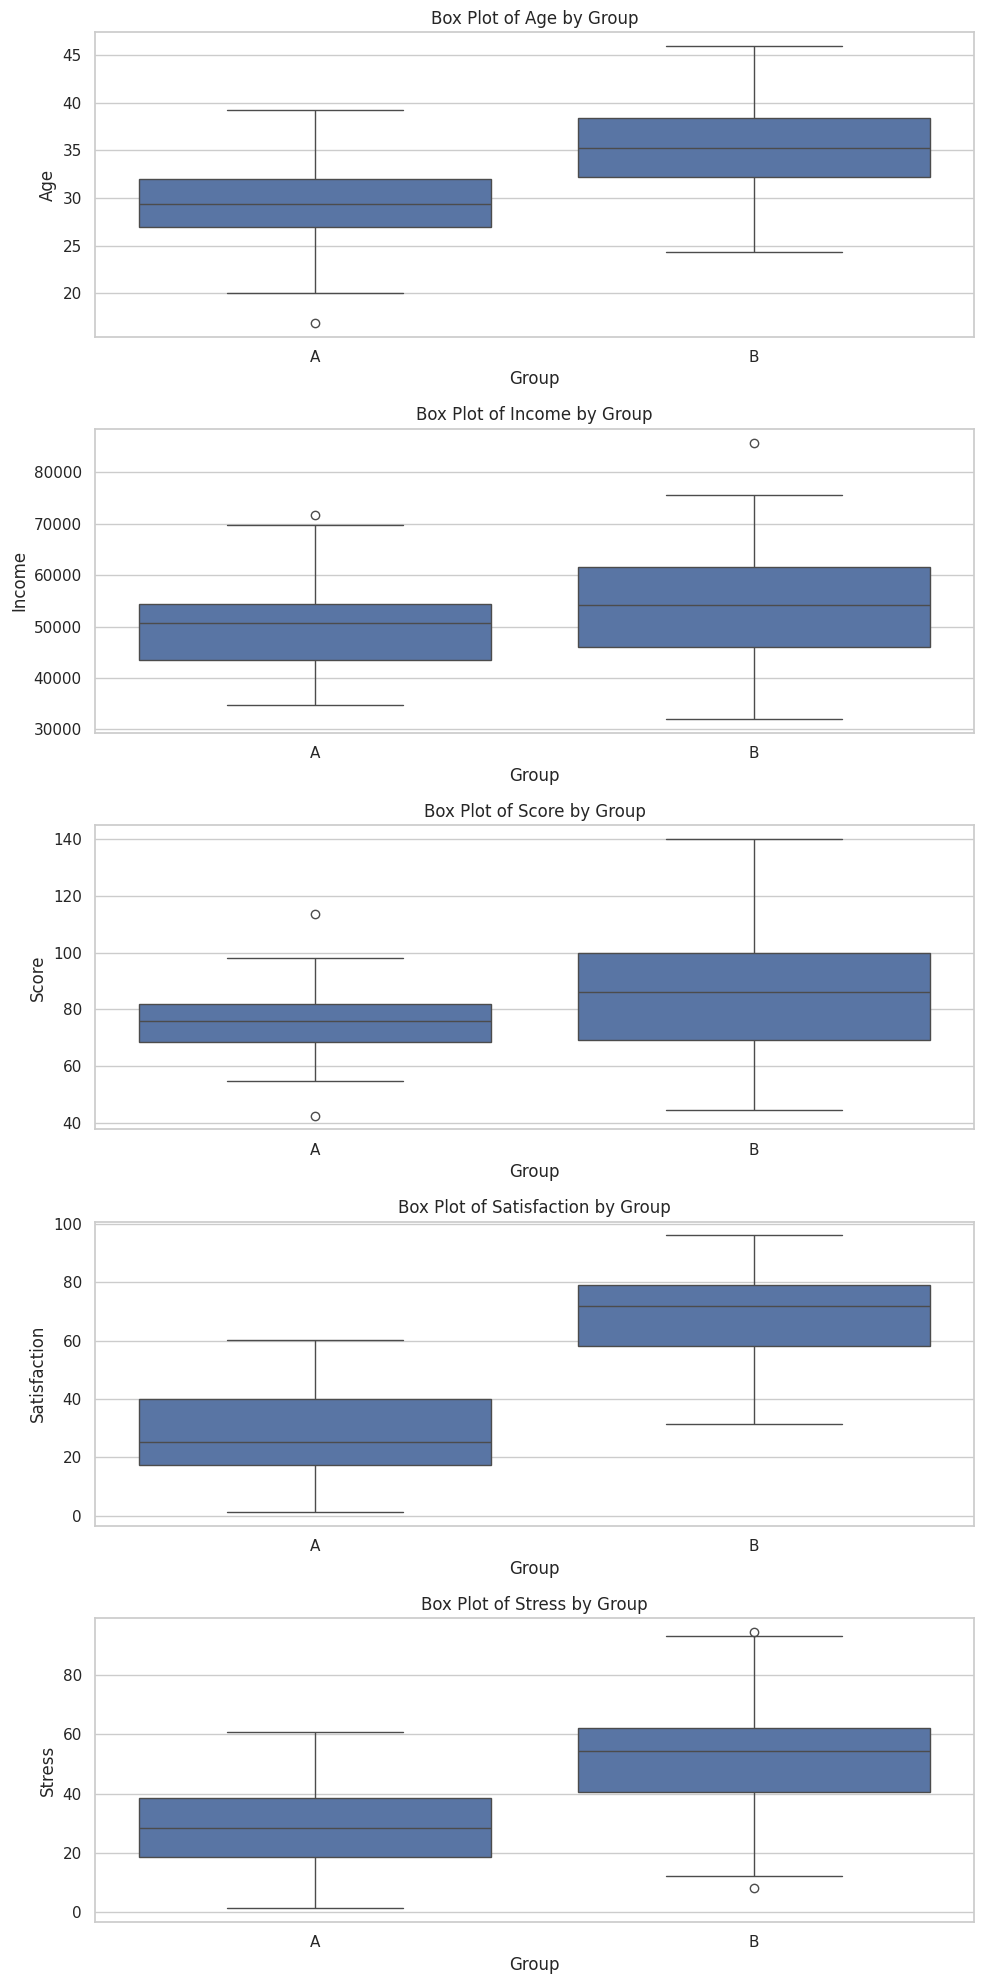

In [26]:
# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Creating a figure to hold the histograms
fig, axes = plt.subplots(5, 1, figsize=(10, 20))

# List of features to plot
features = ['Age', 'Income', 'Score', 'Satisfaction', 'Stress']

# Plotting histograms for each feature
for i, feature in enumerate(features):
    sns.histplot(data, x=feature, hue='Group', element='step', stat='density', common_norm=False, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} by Group')
    axes[i].legend(title='blue=A,orange=B')



plt.tight_layout()
plt.show()

# Creating a figure for box plots
fig, axes = plt.subplots(5, 1, figsize=(10, 20))

# Plotting box plots for each feature
for i, feature in enumerate(features):
    sns.boxplot(x='Group', y=feature, data=data, ax=axes[i])
    axes[i].set_title(f'Box Plot of {feature} by Group')

plt.tight_layout()
plt.show()

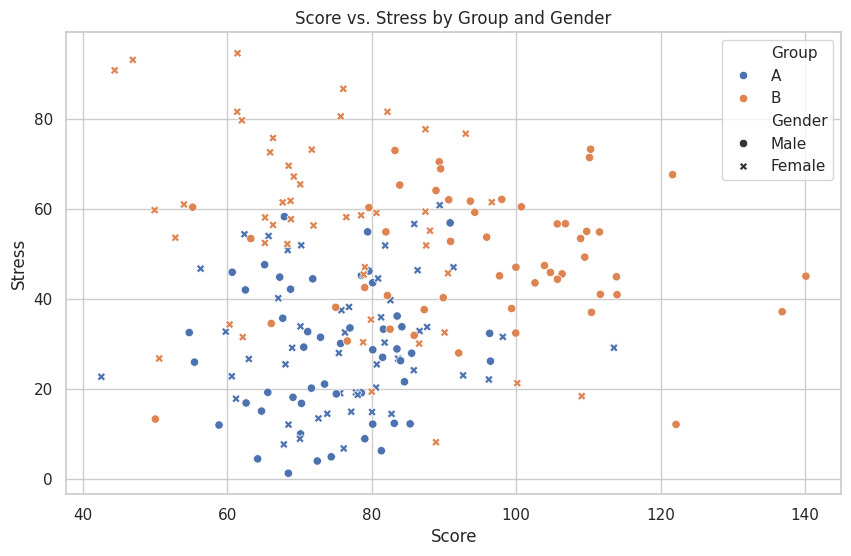

In [27]:
# Creating 2D scatter plots for Score vs Stress
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot for Score vs Stress
sns.scatterplot(data=data, x='Score', y='Stress', hue='Group', style='Gender', ax=ax)
ax.set_title('Score vs. Stress by Group and Gender')
plt.show()

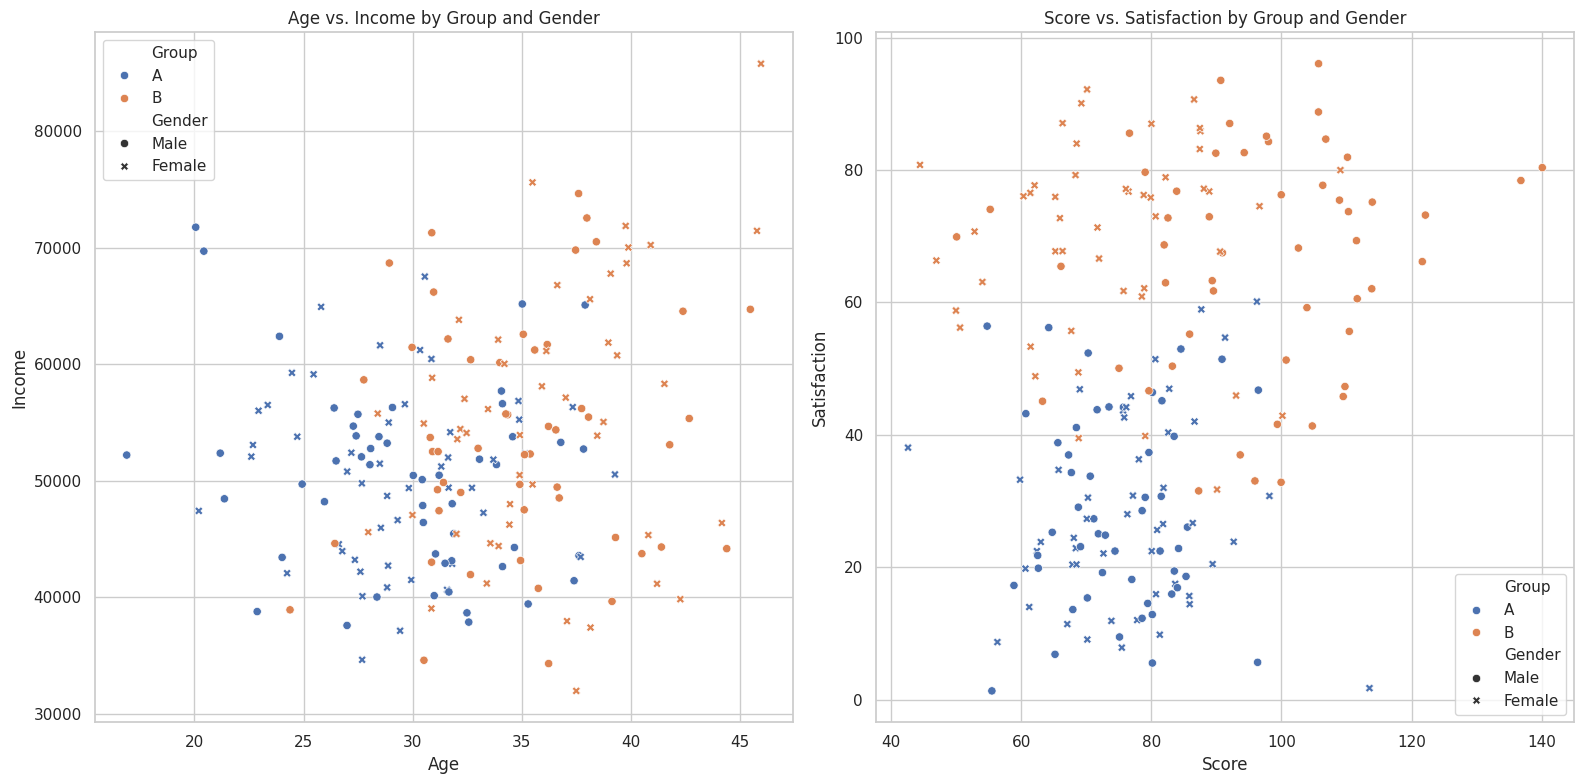

In [28]:
# Creating 2D scatter plots for Age vs Income and Score vs Satisfaction
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Age vs Income
sns.scatterplot(data=data, x='Age', y='Income', hue='Group', style='Gender', ax=axes[0])
axes[0].set_title('Age vs. Income by Group and Gender')

# Score vs Satisfaction
sns.scatterplot(data=data, x='Score', y='Satisfaction', hue='Group', style='Gender', ax=axes[1])
axes[1].set_title('Score vs. Satisfaction by Group and Gender')

plt.tight_layout()
plt.show()